# 04. Particles in Harmonic Well

Here we show how to run some basic particle simulations in a harmonic well. We make use of other Python libraries, like getting random numbers and making complex plots.

In [1]:
# disable GPU. Remove this if you've compiled HOOMD for GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'


import hoomd, hoomd.htf as htf, hoomd.md
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import tensorflow as tf

## Build the computational graph

Our model is relatively simply. We just compute the distance from the origin and square that to get a harmonic potential.

In [2]:
class HarmonicModel(htf.SimModel):
    def compute(self, nlist, positions):
        # Energy is distance from origin squared
        energy = tf.reduce_sum(tf.norm(positions[:, :2], axis=1))
        forces = htf.compute_positions_forces(positions, energy)
        return forces, positions
model = HarmonicModel(0)

## Build Initial Config

We make the starting momentum and positions random for our particles and create s snapshot to use in hoomd-blue.

In [3]:
c = hoomd.context.initialize('--mode=cpu')
# set-up initial distribution
p0bar = [[1,0], [0.1,0.1]]
q0bar = [[-3, -1.5], [0.05, 0.05]]
N = 512 # number of particles
T = 1000 # length of trajectories
P = 32 # period of saving positions

snapshot = hoomd.data.make_snapshot(N=N,
                                    box=hoomd.data.boxdim(Lx=100,
                                                          Ly=100,
                                                          Lz=1),
                                    particle_types=['A'])
q0 = np.zeros((N,3))
q0[:,0] = ss.norm.rvs(scale=q0bar[1][0], loc=q0bar[0][0], size=N)
q0[:,1] = ss.norm.rvs(scale=q0bar[1][1], loc=q0bar[0][1], size=N)
p0 = np.zeros((N,3))
p0[:,0] = ss.norm.rvs(scale=p0bar[1][0], loc=p0bar[0][0], size=N)
p0[:,1] = ss.norm.rvs(scale=p0bar[1][1], loc=p0bar[0][1], size=N)

snapshot.particles.position[:] = q0
snapshot.particles.velocity[:] = p0
snapshot.particles.typeid[:] = 0
system = hoomd.init.read_snapshot(snapshot)

HOOMD-blue 2.5.2 DOUBLE HPMC_MIXED TBB SSE SSE2 SSE3 
Compiled: 04/30/2019
Copyright (c) 2009-2019 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, C D Lorenz, and A Travesset. "General purpose molecular dynamics
  simulations fully implemented on graphics processing units", Journal of
  Computational Physics 227 (2008) 5342--5359
* J Glaser, T D Nguyen, J A Anderson, P Liu, F Spiga, J A Millan, D C Morse, and
  S C Glotzer. "Strong scaling of general-purpose molecular dynamics simulations
  on GPUs", Computer Physics Communications 192 (2015) 97--107
-----
HOOMD-blue is running on the CPU
notice(2): Group "all" created containing 512 particles


## Run the simulation
Now we run the simulation in the NVE ensemble. We disable the hoomd-blue sorter, so that the particle ordering doesn't change. This makes it easy to plot the particles

In [4]:
# run Hoomd-blue simulation
tfcompute = htf.tfcompute(model)
tfcompute.attach(save_output_period=P)
hoomd.md.integrate.mode_standard(dt=0.001)
hoomd.md.integrate.nve(group=hoomd.group.all())                                   
c.sorter.disable()
hoomd.run(T * P)

notice(2): Force mode is FORCE_MODE.tf2hoomd 
notice(2): Starting TensorflowCompute 
notice(2): completed reallocate
notice(2): Setting flag indicating virial modification will occur
** starting run **
Time 00:00:10 | Step 8714 / 32000 | TPS 871.348 | ETA 00:00:26
Time 00:00:20 | Step 18317 / 32000 | TPS 960.244 | ETA 00:00:14
Time 00:00:30 | Step 27103 / 32000 | TPS 878.006 | ETA 00:00:05
Time 00:00:35 | Step 32000 / 32000 | TPS 864.572 | ETA 00:00:00
Average TPS: 897.044
---------
** run complete **


## Load and plot

Now we plot

In [5]:
# load particle trajectories
paths = np.empty((T, N, 2) )
for i in range(1,T):
    paths[i] = tfcompute.outputs[0][i,:,:2]

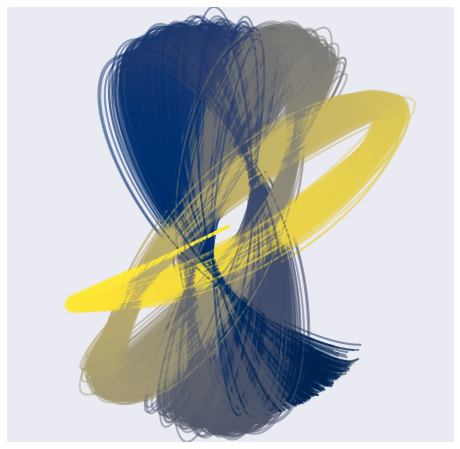

In [6]:
# plot particle trajectories
def make_segments(data, particle_index):
    points = np.array([data[:,particle_index, 0], data[:,particle_index, 1]]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments

from matplotlib.collections import LineCollection
plt.figure(figsize=(8,8))
plt.style.use('seaborn-dark')
for i in range(N):
    lc = LineCollection(make_segments(paths, i), cmap='cividis', norm=plt.Normalize(0,1), alpha=0.5)
    # Set the values used for colormapping
    lc.set_array(np.linspace(1,0,T))
    lc.set_linewidth(2)
    line = plt.gca().add_collection(lc)
plt.xlim(np.nanmin(paths), np.nanmax(paths))
plt.ylim(np.nanmin(paths), np.nanmax(paths))
plt.xticks([])
plt.yticks([])
plt.savefig('normal.png', dpi=90)
plt.show()